In [1]:
# !mkdir celeba_gan
# !gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
# !unzip -qq celeba_gan/data.zip -d celeba_gan

mkdir: cannot create directory ‘celeba_gan’: File exists
/home/nacho/anaconda3/envs/tf/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=639a3ddb-c6fa-4a23-a51c-1c7eec672380
To: /home/nacho/Documents/dlpyhton/tf_examples/generative/image_generation/celeba_gan/data.zip
100%|██████████████████████████████████████| 1.44G/1.44G [00:33<00:00, 43.2MB/s]
replace celeba_gan/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    './celeba_gan',
    label_mode = None,
    image_size = (64, 64),
    batch_size = 64,
    smart_resize= True
)

In [3]:
dataset = dataset.map(lambda x: x / 255.)

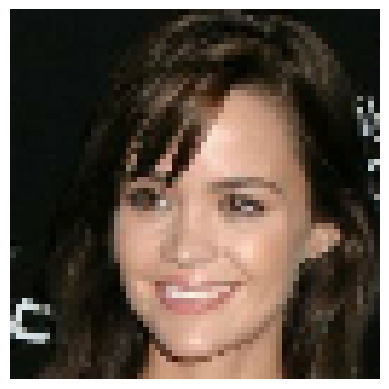

In [4]:
import matplotlib.pyplot as plt
sample = next(iter(dataset))
plt.axis('off')
plt.imshow((sample.numpy()*255).astype('int32')[0])

In [5]:
from tensorflow.keras import layers

discriminator = keras.Sequential([
    keras.Input(shape = (64, 64, 3)),
    layers.Conv2D(64, 4, 2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, 4, 2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, 4, 2, padding='same'),
    layers.LeakyReLU(0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name = 'discriminator')

In [6]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [7]:
latent_dim = 256

generator = keras.Sequential([
    keras.Input(shape = (latent_dim,)),
    layers.Dense(8 * 8 * 128, activation = 'relu'),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, 4, 2, padding='same'),
    layers.ReLU(),
    layers.Conv2DTranspose(256, 4, 2, padding='same'),
    layers.ReLU(),
    layers.Conv2DTranspose(512, 4, 2, padding='same'),
    layers.ReLU(),
    layers.Conv2D(3, 5, padding='same', activation = 'sigmoid'),
], name = 'generator')

In [8]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              2105344   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 re_lu (ReLU)                (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 256)       0 

In [9]:
import tensorflow as tf

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vector = tf.random.normal([batch_size, latent_dim])
        generated_images = self.generator(random_latent_vector)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        random_latent_vector = tf.random.normal([batch_size, latent_dim])
        
        misleading_labels = tf.zeros([batch_size, 1])
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vector))
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }

In [10]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=256):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vector = tf.random.normal([self.num_img, self.latent_dim])
        generated_images = self.model.generator(random_latent_vector)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f'generated_image_{epoch:03d}_{i}.png')

In [11]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.00001), 
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
            loss_fn=keras.losses.BinaryCrossentropy())

In [12]:
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)])

Epoch 1/200


2024-01-03 10:16:28.858040: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-03 10:16:28.889871: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-03 10:16:29.047753: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-01-03 10:16:32.007742: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-03 10:16:32.260066: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilatio

3166/3166 [==============================] - 399s 122ms/step - d_loss: 0.6665 - g_loss: 1.1487
Epoch 2/200
3166/3166 [==============================] - 373s 118ms/step - d_loss: 0.7072 - g_loss: 0.7938
Epoch 3/200
3166/3166 [==============================] - 373s 118ms/step - d_loss: 0.7054 - g_loss: 0.7189
Epoch 4/200
3166/3166 [==============================] - 375s 118ms/step - d_loss: 0.6976 - g_loss: 0.7304
Epoch 5/200
3166/3166 [==============================] - 372s 117ms/step - d_loss: 0.6954 - g_loss: 0.7308
Epoch 6/200
3166/3166 [==============================] - 357s 113ms/step - d_loss: 0.6939 - g_loss: 0.7358
Epoch 7/200
3166/3166 [==============================] - 402s 127ms/step - d_loss: 0.6931 - g_loss: 0.7411
Epoch 8/200
3166/3166 [==============================] - 397s 125ms/step - d_loss: 0.6926 - g_loss: 0.7421
Epoch 9/200
3166/3166 [==============================] - 382s 121ms/step - d_loss: 0.6927 - g_loss: 0.7445
Epoch 10/200
3166/3166 [=========================

KeyboardInterrupt: 